数据集加载完成！
开始训练...
Epoch 1/10: Train Loss: 0.3948, Train Acc: 0.879, Test Acc: 0.948, Time: 13.29 sec
Epoch 2/10: Train Loss: 0.0820, Train Acc: 0.974, Test Acc: 0.968, Time: 25.55 sec
Epoch 3/10: Train Loss: 0.0551, Train Acc: 0.983, Test Acc: 0.976, Time: 33.41 sec
Epoch 4/10: Train Loss: 0.0426, Train Acc: 0.986, Test Acc: 0.974, Time: 21.26 sec
Epoch 5/10: Train Loss: 0.0354, Train Acc: 0.989, Test Acc: 0.986, Time: 21.88 sec
Epoch 6/10: Train Loss: 0.0292, Train Acc: 0.991, Test Acc: 0.981, Time: 23.69 sec
Epoch 7/10: Train Loss: 0.0246, Train Acc: 0.992, Test Acc: 0.986, Time: 22.49 sec
Epoch 8/10: Train Loss: 0.0210, Train Acc: 0.994, Test Acc: 0.988, Time: 22.43 sec
Epoch 9/10: Train Loss: 0.0183, Train Acc: 0.994, Test Acc: 0.957, Time: 19.75 sec
Epoch 10/10: Train Loss: 0.0164, Train Acc: 0.995, Test Acc: 0.989, Time: 19.86 sec
总训练时间: 223.59 秒


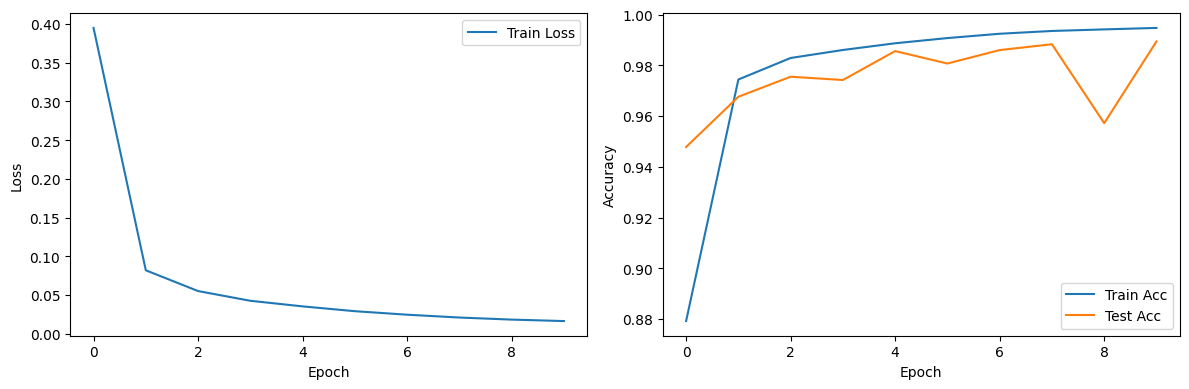

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time


# 1. 加载MNIST数据集，并返回训练集和测试集的数据加载器
def load_data_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

    print("数据集加载完成！")
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)
    )


# 2. 卷积神经网络模型，加入残差连接
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 第一阶段：卷积 + 池化
        self.conv1 = nn.Conv2d(1, 10, 5)  # 输入1通道，输出10通道，卷积核5x5
        self.pool1 = nn.MaxPool2d(2, 2)   # 池化后尺寸从 28x28 -> 12x12（实际为12因为 kernel=5, stride默认=1）

        # 第二阶段：残差块
        self.conv2a = nn.Conv2d(10, 20, 3, padding=1)  # 维度不变
        self.conv2b = nn.Conv2d(20, 20, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 再池化一层使尺寸变小以适配全连接

        # 输出层
        self.fc1 = nn.Linear(20 * 6 * 6, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # 第一层卷积 + ReLU + 池化
        out = self.pool1(torch.relu(self.conv1(x)))  # -> [batch, 10, 12, 12]

        # 残差块
        identity = out  # 保存输入
        out = torch.relu(self.conv2a(out))           # -> [batch, 20, 12, 12]
        out = self.conv2b(out)                        # -> [batch, 20, 12, 12]

        # 为了做残差连接，需要把 identity 从10通道升维到20通道
        if identity.shape[1] != out.shape[1]:
            identity = nn.functional.pad(identity, (0, 0, 0, 0, 0, 10))  # 填充通道维度 (channel dim)

        out += identity                # 残差连接
        out = torch.relu(out)          # 激活
        out = self.pool2(out)          # -> [batch, 20, 6, 6]

        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


# 3. 训练神经网络模型 并评估其性能，加入训练时间统计
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.1):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    print("开始训练...")
    total_start_time = time.time()  # 总训练开始时间

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # 当前epoch开始时间

        total_loss, total_correct, total_samples = 0, 0, 0

        for X, y in train_iter:
            output = net(X)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0)

        train_loss = total_loss / len(train_iter)
        train_acc = total_correct / total_samples

        test_correct, test_samples = 0, 0
        with torch.no_grad():
            for X, y in test_iter:
                output = net(X)
                test_correct += (output.argmax(dim=1) == y).sum().item()
                test_samples += y.size(0)
        test_acc = test_correct / test_samples

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.3f}, '
              f'Test Acc: {test_acc:.3f}, '
              f'Time: {epoch_time:.2f} sec')

    total_time = time.time() - total_start_time
    print(f"总训练时间: {total_time:.2f} 秒")

    # 可视化
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    torch.manual_seed(42)

    batch_size = 256
    num_epochs = 10
    learning_rate = 0.1

    train_iter, test_iter = load_data_mnist(batch_size)
    model = ConvNet()
    train_model(model, train_iter, test_iter, num_epochs, learning_rate)
